# Error Analysis on the Classification Results

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import re
import json
from typing import List
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from helpers.helpersParsingResults import parse_ground_truth_and_predictions, import_HIPE_results, parse_model_results, get_global_sent_metrics, plot_results

In [2]:
PRED_DIR = "./experiments"
TRUE_DIR = "./../data/"
DATA_DIR = "./../data/"

TRUE_FILES = {"de": {"dev": "de/newsagency-data-2-dev-de.tsv", 
                     "test": "de/newsagency-data-2-test-de.tsv"},
              "fr": {"dev": "fr/newsagency-data-2-dev-fr.tsv", 
                     "test": "fr/newsagency-data-2-test-fr.tsv"}
}

PRED_FILES = {
    "de": {"dev": "newsagency-data-2-dev-de_pred.tsv", 
           "test": "newsagency-data-2-test-de_pred.tsv"},
    "fr": {"dev": "newsagency-data-2-dev-fr_pred.tsv", 
           "test": "newsagency-data-2-test-fr_pred.tsv"}
}

### Get Best Run per Model

In [3]:
def get_all_best_model_runs(models_dir, set="test"):
    df_best = pd.DataFrame()

    all_ne_global_metrics, _, _, _, _ = parse_model_results(models_dir)
    df = all_ne_global_metrics[all_ne_global_metrics["set"]==set]

    df["name"] = df["model"] + "_" + df["max_sequence_length"].astype(str) + "_" + df["language"] + "_" + set
    df["lang"] = df["language"].apply(lambda x: "multilingual" if "multi" in x else x)
    df["modelname"] = "model_" + df["model"] + "_max_sequence_length_" + df["max_sequence_length"].astype(str) + "_epochs_3_run_" + df["lang"] + "_" + df["run"].astype(str)
    for name in df["name"].unique():
        df_sel = df[df["name"] == name].reset_index()
        max_id = df_sel["f1"].idxmax()
        df_best = pd.concat([df_best, df_sel.iloc[[max_id]]])
    
    return df_best

def get_best_run(df_best, name):
    best_run = df_best[df_best["name"]==name][["run", "modelname"]]
    return best_run["modelname"].values[0] #, best_run["run"].values[0]

In [4]:
df_best = get_all_best_model_runs(PRED_DIR)
df_best.head()

,index,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1,name,lang,modelname
0,1,bert_base_german_cased,128,3,_run_de_2,test,de,2,0.050078,0.867925,0.867925,0.867925,bert_base_german_cased_128_de_test,de,model_bert_base_german_cased_max_sequence_leng...
4,579,xlm_roberta_base,256,3,_run_de_3,test,de,3,0.087942,0.822222,0.698113,0.755102,xlm_roberta_base_256_de_test,de,model_xlm_roberta_base_max_sequence_length_256...
2,415,bert_base_multilingual_cased,256,3,_run_multilingual-de_2,test,multilingual-de,2,0.119466,0.775862,0.849057,0.810811,bert_base_multilingual_cased_256_multilingual-...,multilingual,model_bert_base_multilingual_cased_max_sequenc...
2,417,bert_base_multilingual_cased,256,3,_run_multilingual-fr_2,test,multilingual-fr,2,0.064805,0.820513,0.810127,0.815287,bert_base_multilingual_cased_256_multilingual-...,multilingual,model_bert_base_multilingual_cased_max_sequenc...
1,27,bert_base_cased,64,3,_run_fr_5,test,fr,5,0.072691,0.777778,0.767123,0.772414,bert_base_cased_64_fr_test,fr,model_bert_base_cased_max_sequence_length_64_e...


In [5]:
get_best_run(df_best, "bert_base_german_cased_128_de_test")

'model_bert_base_german_cased_max_sequence_length_128_epochs_3_run_de_2'

In [6]:
get_best_run(df_best, "dbmdz_bert_base_french_europeana_cased_128_fr_test")

'model_dbmdz_bert_base_french_europeana_cased_max_sequence_length_128_epochs_3_run_fr_5'

## Parse Prediction and Ground Truth File

In [7]:
def parse_tsv_gt_and_prediction(model_dir: str, set="dev", lang="de",
                                true_dir = TRUE_DIR, true_files=TRUE_FILES, pred_dir=PRED_DIR, pred_files=PRED_FILES):
    #get ground truth
    true_file = os.path.join(true_dir, true_files[lang][set])
    with open(true_file, "r") as f:
        true_lines = [line for line in f]

    #get predictions
    pred_file = os.path.join(pred_dir, model_dir, pred_files[lang][set])
    with open(pred_file, "r") as f:
        pred_lines = [line for line in f]

    return parse_ground_truth_and_predictions(pred_lines, true_lines)

In [8]:
models_to_import = [
    "bert_base_cased_128_de_test",
    "bert_base_cased_256_de_test",
    "bert_base_cased_512_de_test",
    "bert_base_german_cased_128_de_test",
    "bert_base_german_cased_256_de_test",
    "bert_base_german_cased_512_de_test",

    "bert_base_cased_128_fr_test",
    "bert_base_cased_256_fr_test",
    "bert_base_cased_512_fr_test",
    "dbmdz_bert_base_french_europeana_cased_128_fr_test",
    "dbmdz_bert_base_french_europeana_cased_256_fr_test",
    "dbmdz_bert_base_french_europeana_cased_512_fr_test"
]

imported_models = {}
for model in models_to_import:
    if ("_de" in model) or ("-de" in model):
        imported_models[model] = parse_tsv_gt_and_prediction(get_best_run(df_best, model), "test", "de")
    elif ("_fr" in model) or ("-fr" in model):
        imported_models[model] = parse_tsv_gt_and_prediction(get_best_run(df_best, model), "test", "fr")
    else:
        print("Could not infer language from model name", model)

In [9]:
imported_models["bert_base_cased_128_de_test"].head()

,token,pred_ag,true_ag,pos_in_doc,len_doc,LED,is_correct_class,at_beginning,at_end,in_middle
0,Ãnjtefi,O,UP-UPI,23.0,1225.0,0.33,False,False,False,True
1,PreÃ,O,UP-UPI,24.0,1225.0,0.33,False,False,False,True
2,Exchange,Extel,Extel,459.0,1225.0,0.00,True,False,False,True
3,DNB,DNB,DNB,536.0,1225.0,0.00,True,False,False,True
4,ag,ag,ag,672.0,1225.0,0.00,True,False,False,True


## Confusion Matrix

In [10]:
def plot_confusion_matrix(df, title, make_plot=False, ax=None):
    true_labels = list(df["true_ag"].unique())
    labels = true_labels + [label for label in list(df["pred_ag"].unique()) if not label in true_labels]
    labels = [entry for entry in labels if not entry == "O"] + ["O"]
    cf_matrix = confusion_matrix(df["true_ag"], df["pred_ag"], labels=labels)

    #plotting
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    s = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, ax=ax, cmap="rocket_r")
    s.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(title)

    if make_plot:
        plt.show()

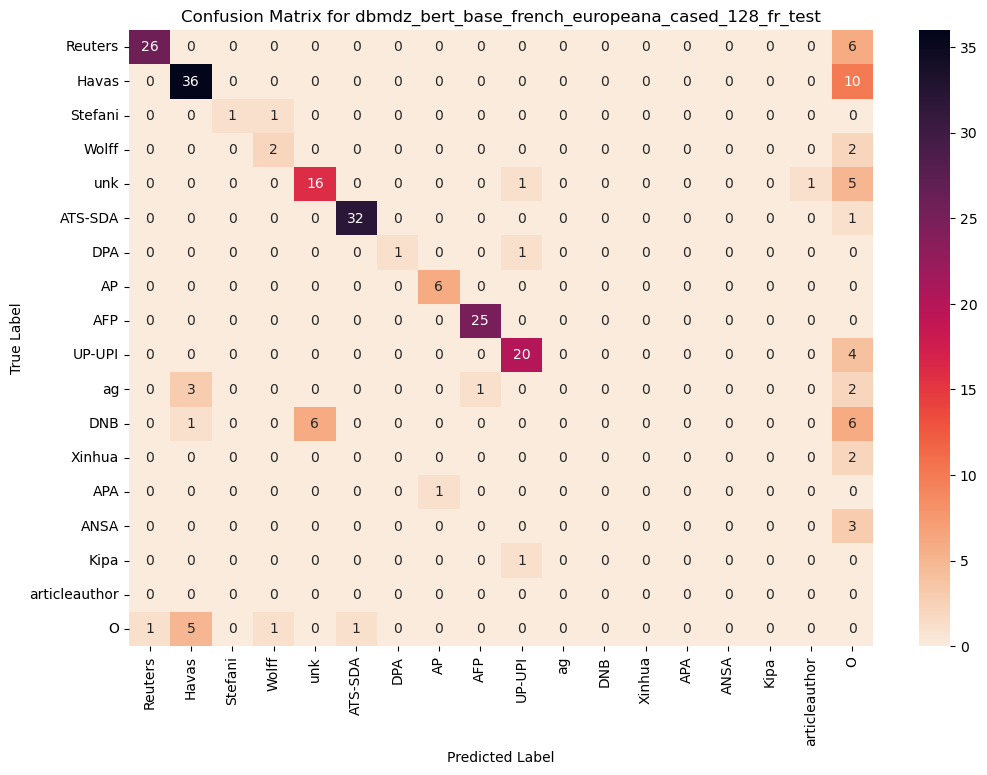

In [11]:
plot_confusion_matrix(imported_models["dbmdz_bert_base_french_europeana_cased_128_fr_test"], "Confusion Matrix for dbmdz_bert_base_french_europeana_cased_128_fr_test")

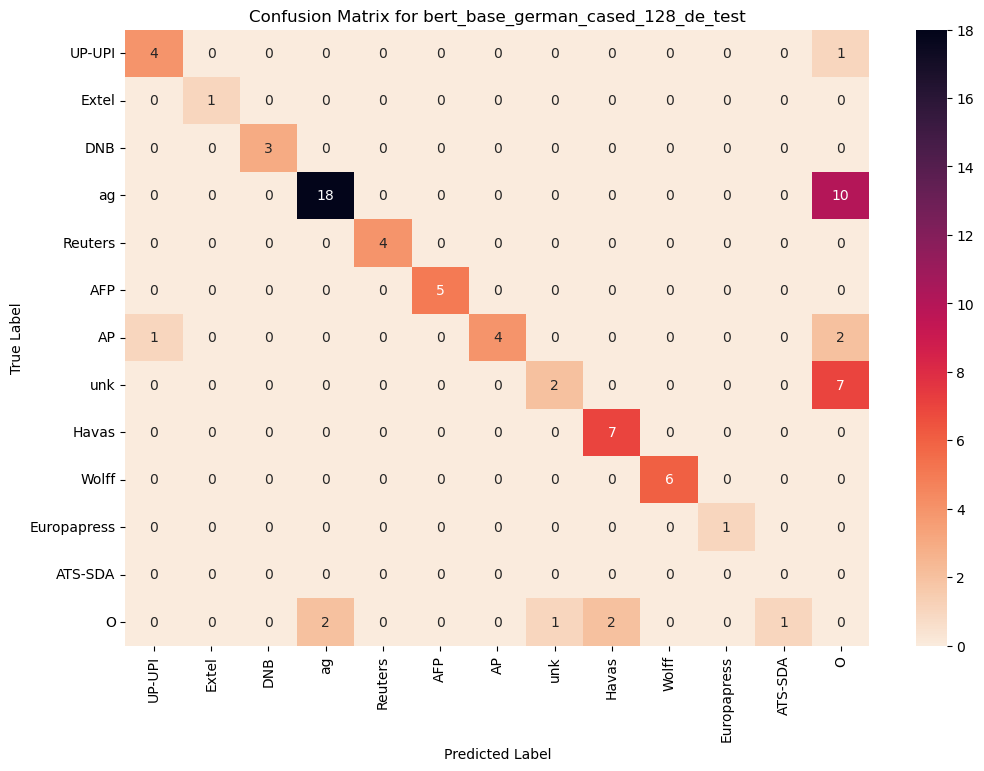

In [12]:
plot_confusion_matrix(imported_models["bert_base_german_cased_128_de_test"], "Confusion Matrix for bert_base_german_cased_128_de_test")

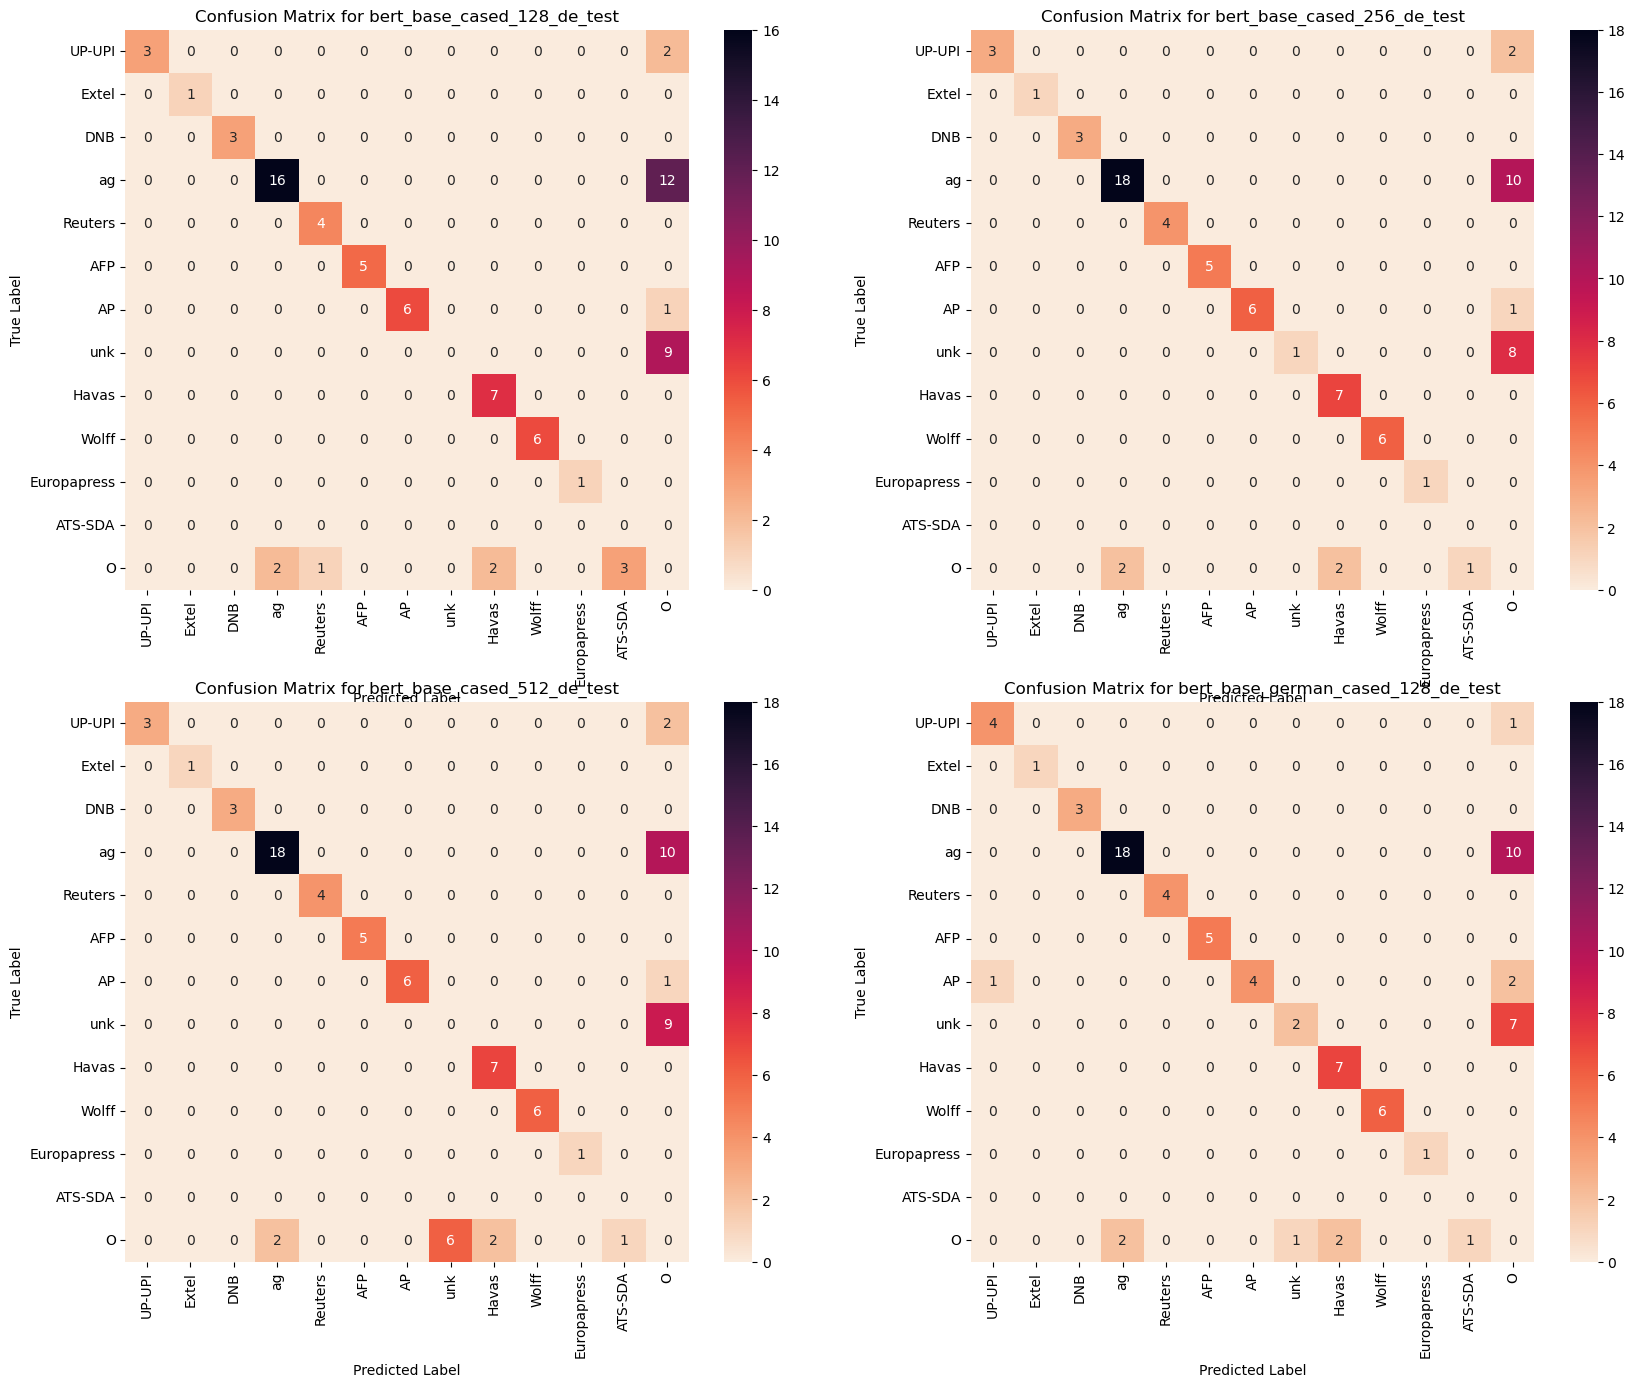

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for (i,j), model in zip([(0,0), (0,1), (1,0), (1,1)], list(imported_models.keys())[:4]):
    plot_confusion_matrix(imported_models[model], f"Confusion Matrix for {model}", ax=axs[i,j])

## Positions of Agencies

In [14]:
def get_correct_ratio_per_pos(df, pos="at_beginning"):
   df_all = df[(df["pred_ag"] != "O") & df[pos] ]
   df_correct = df_all[df_all["is_correct_class"]]
   # avoid division by 0
   if len(df_all) == 0:
      return None
   else:
      return round(len(df_correct)/len(df_all)*100, 2)

def get_correct_ratios(df):
   percs = {}
   percs["at_beginning"] = get_correct_ratio_per_pos(df, "at_beginning")
   percs["in_middle"] = get_correct_ratio_per_pos(df, "in_middle")
   percs["at_end"] = get_correct_ratio_per_pos(df, "at_end")
   return percs

In [15]:
def get_all_df_pos(imported_models):
    positions_dict = {
        "model": [],
        "at_beginning": [],
        "in_middle": [],
        "at_end": []
    }
    for model, model_df in imported_models.items():
        percs = get_correct_ratios(model_df)
        positions_dict["model"].append(model)
        positions_dict["at_beginning"].append(percs["at_beginning"])
        positions_dict["in_middle"].append(percs["in_middle"])
        positions_dict["at_end"].append(percs["at_end"])

    df_pos = pd.DataFrame(positions_dict)
    return df_pos
df_pos = get_all_df_pos(imported_models)
df_pos.head()

,model,at_beginning,in_middle,at_end
0,bert_base_cased_128_de_test,100.0,85.96,NaN
1,bert_base_cased_256_de_test,100.0,91.23,NaN
2,bert_base_cased_512_de_test,100.0,82.26,NaN
3,bert_base_german_cased_128_de_test,100.0,88.14,NaN
4,bert_base_german_cased_256_de_test,100.0,84.75,NaN


[]

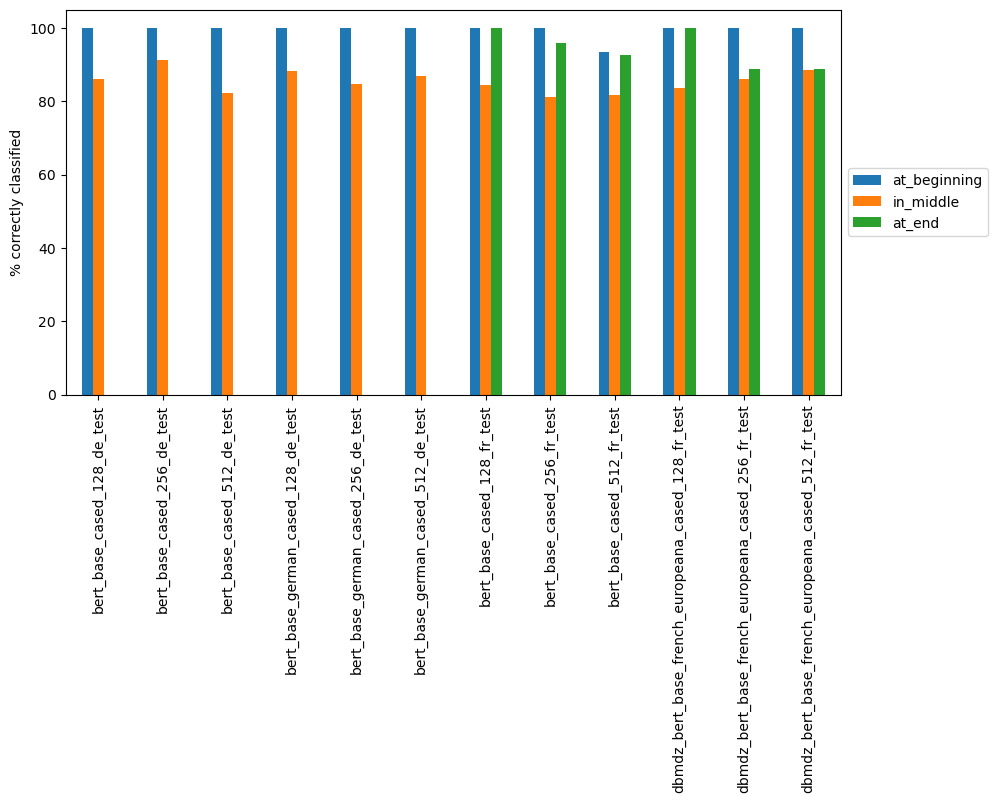

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
df_pos.plot.bar(ax=ax)
ax.set_xticklabels(df_pos["model"])
ax.set_ylabel("% correctly classified")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.plot()

## OCR Noise

In [17]:
def get_correct_ratio_per_noise(df):
    df_equal_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] == 0 ]
    df_bigger_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] > 0 ]
    df_equal_0_correct = df_equal_0[df_equal_0["is_correct_class"]]
    df_bigger_0_correct = df_bigger_0[df_bigger_0["is_correct_class"]]

    len_equal = len(df_equal_0)
    len_bigger = len(df_bigger_0)

    return {
        "LED == 0": (round(len(df_equal_0_correct)/len_equal *100, 2), len_equal) if len_equal > 0 else None,
        "LED > 0": (round(len(df_bigger_0_correct)/len_bigger *100, 2), len_bigger) if len_bigger > 0 else None,
    }

In [18]:
for model, model_df in imported_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratio_per_noise(model_df)}\n")

bert_base_cased_128_de_test - % of correctly predicted news agencies:
{'LED == 0': (61.45, 83), 'LED > 0': (100.0, 1)}

bert_base_cased_256_de_test - % of correctly predicted news agencies:
{'LED == 0': (67.5, 80), 'LED > 0': (100.0, 1)}

bert_base_cased_512_de_test - % of correctly predicted news agencies:
{'LED == 0': (61.63, 86), 'LED > 0': (100.0, 1)}

bert_base_german_cased_128_de_test - % of correctly predicted news agencies:
{'LED == 0': (66.25, 80), 'LED > 0': (100.0, 2)}

bert_base_german_cased_256_de_test - % of correctly predicted news agencies:
{'LED == 0': (62.65, 83), 'LED > 0': (100.0, 1)}

bert_base_german_cased_512_de_test - % of correctly predicted news agencies:
{'LED == 0': (74.39, 82), 'LED > 0': (50.0, 2)}

bert_base_cased_128_fr_test - % of correctly predicted news agencies:
{'LED == 0': (70.87, 230), 'LED > 0': (100.0, 5)}

bert_base_cased_256_fr_test - % of correctly predicted news agencies:
{'LED == 0': (69.0, 229), 'LED > 0': (66.67, 3)}

bert_base_cased_512_

#### HIPE Data

In [19]:
NOISE_LEVELS = ["LED-0.0-0.0", "LED-0.001-0.1", "LED-0.1-0.3", "LED-0.3-1.1"]
TIME_LEVELS = ["TIME-1800-1900", "TIME-1900-1940", "TIME-1940-2000"]

In [20]:
noise_dev_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir=PRED_DIR)
grouped_noise_dev_HIPE = noise_dev_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_dev_HIPE.head()

model language max_sequence_length    noise_level   run  \
                                                               count   
0  bert_base_cased       de                  64    LED-0.0-0.0     5   
1  bert_base_cased       de                  64  LED-0.001-0.1     5   
2  bert_base_cased       de                  64    LED-0.1-0.3     5   
3  bert_base_cased       de                  64    LED-0.3-1.1     5   
4  bert_base_cased       de                 128    LED-0.0-0.0     5   

   F1_micro           F1_macro_doc            TP  FN  
       mean       std         mean       std sum sum  
0  0.715568  0.067859     0.928593  0.037733  70  20  
1  0.000000  0.000000          NaN       NaN   0   0  
2  0.000000  0.000000          NaN       NaN   0   5  
3  0.177778  0.205631     1.000000  0.000000   3   2  
4  0.747895  0.031765     0.934074  0.019059  74  16

In [21]:
noise_test_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir=PRED_DIR, set="test")
grouped_noise_test_HIPE = noise_test_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_test_HIPE.tail()

model         language max_sequence_length    noise_level  \
                                                                            
315  xlm_roberta_base  multilingual-fr                 256    LED-0.3-1.1   
316  xlm_roberta_base  multilingual-fr                 512    LED-0.0-0.0   
317  xlm_roberta_base  multilingual-fr                 512  LED-0.001-0.1   
318  xlm_roberta_base  multilingual-fr                 512    LED-0.1-0.3   
319  xlm_roberta_base  multilingual-fr                 512    LED-0.3-1.1   

      run  F1_micro          F1_macro_doc             TP   FN  
    count      mean      std         mean       std  sum  sum  
315     5  0.000000  0.00000     0.000000  0.000000    0   20  
316     5  0.238686  0.12733     0.346085  0.105621  128  447  
317     5  0.000000  0.00000          NaN       NaN    0    0  
318     5  0.000000  0.00000     0.000000  0.000000    0   35  
319     5  0.000000  0.00000     0.000000  0.000000    0   20

In [22]:
df_noise = grouped_noise_test_HIPE.dropna()
df_noise = df_noise.groupby(["model", "language", "noise_level"]).agg(np.mean).reset_index()
df_noise.columns = df_noise.columns.map("".join)
df_noise = df_noise.rename(columns={"F1_micromean": "F1_micro_mean"})[["model", "language", "noise_level", "F1_micro_mean"]]
df_noise["name"] = df_noise["model"] + "_" + df_noise["language"]
df_noise_de = df_noise[df_noise["language"].isin(["de", "multilingual-de"])].pivot(index="noise_level", columns="name", values="F1_micro_mean")
df_noise_fr = df_noise[df_noise["language"].isin(["fr", "multilingual-fr"])].pivot(index="noise_level", columns="name", values="F1_micro_mean")
df_noise_de.head()

/tmp/ipykernel_3829516/137834855.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_noise = df_noise.groupby(["model", "language", "noise_level"]).agg(np.mean).reset_index()


name,bert_base_cased_de,bert_base_cased_multilingual-de,bert_base_german_cased_de,bert_base_multilingual_cased_de,bert_base_multilingual_cased_multilingual-de,dbmdz_bert_base_german_europeana_cased_de,dbmdz_bert_base_historic_multilingual_cased_de,dbmdz_bert_base_historic_multilingual_cased_multilingual-de,xlm_roberta_base_de,xlm_roberta_base_multilingual-de
noise_level,,,,,,,,,,
LED-0.0-0.0,0.798868,0.788263,0.798724,0.279212,0.606304,0.570362,0.347332,0.679414,0.623419,0.599638
LED-0.1-0.3,0.225779,0.191923,0.233922,0.044444,0.055230,0.104523,NaN,0.063182,0.244502,0.106115


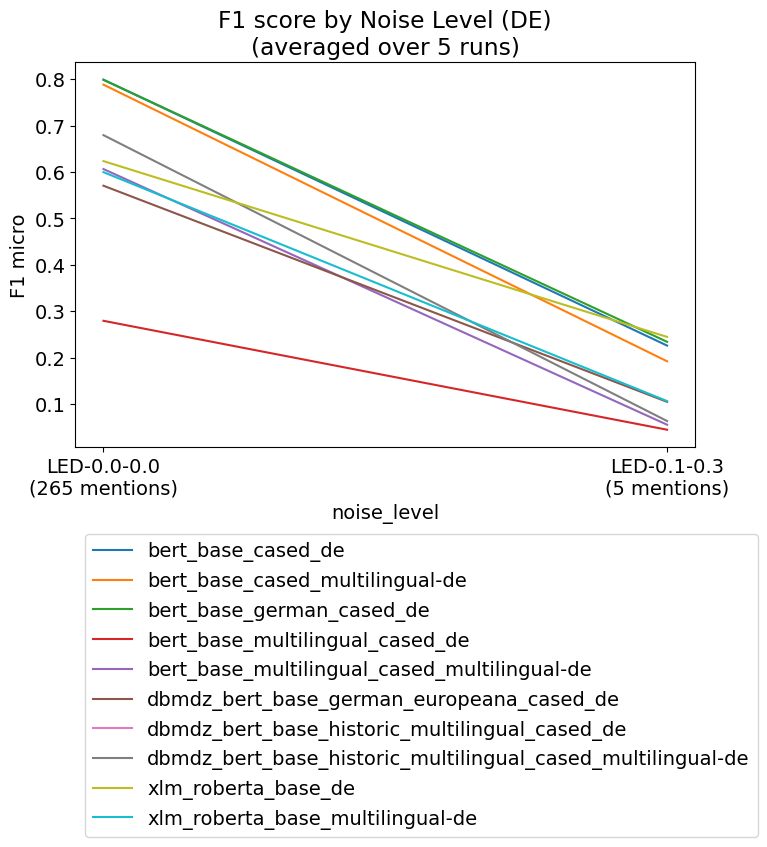

In [23]:
matplotlib.rcParams.update({'font.size': 14})

f = plt.figure(figsize=(8,5))

plt.title('F1 score by Noise Level (DE)\n(averaged over 5 runs)', color='black')
ax = df_noise_de.plot(kind='line', ax=f.gca())
ax.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticks([0,1])
xlabels = [f"{df_noise_de.index[0]}\n(265 mentions)", f"{df_noise_de.index[1]}\n(5 mentions)"]
ax.set_xticklabels(xlabels)
ax.set_ylabel("F1 micro")
plt.legend(bbox_to_anchor=(0, -0.2), loc="upper left")
plt.show()

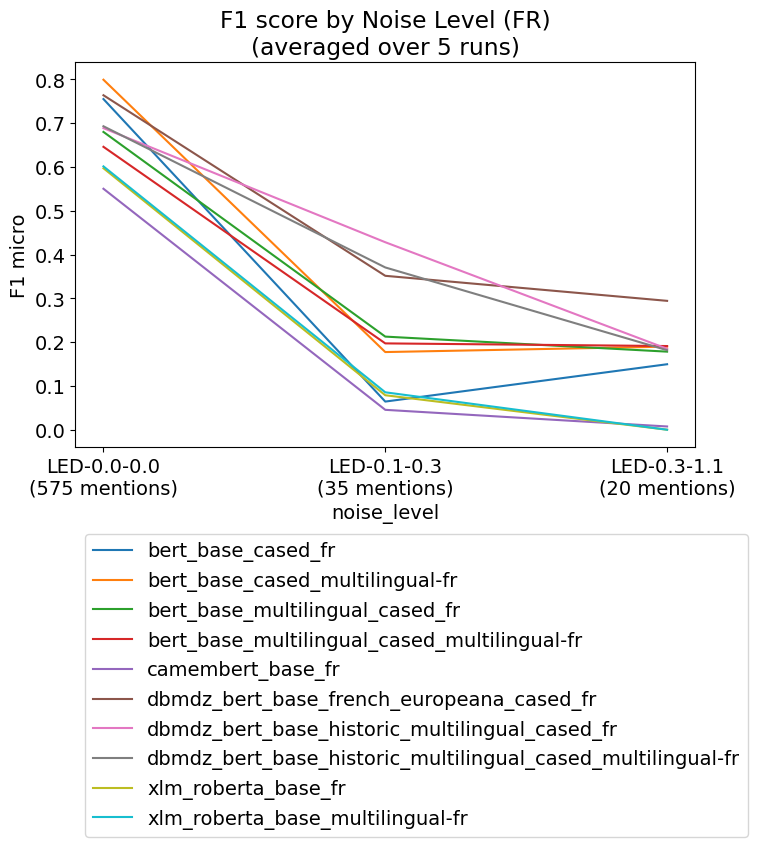

In [24]:
f = plt.figure(figsize=(8,5))

plt.title('F1 score by Noise Level (FR)\n(averaged over 5 runs)', color='black')
ax = df_noise_fr.plot(kind='line', ax=f.gca())
ax.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticks([0,1,2])
xlabels = [f"{df_noise_fr.index[0]}\n(575 mentions)", f"{df_noise_fr.index[1]}\n(35 mentions)", f"{df_noise_fr.index[2]}\n(20 mentions)"]
ax.set_xticklabels(xlabels)
ax.set_ylabel("F1 micro")

plt.legend(bbox_to_anchor=(0, -0.2), loc="upper left")
plt.show()

## Swapped Agencies

In [25]:
ne_global_metrics, ne_dev_metrics, ne_test_metrics,  sent_dev_metrics, sent_test_metrics = parse_model_results(os.path.join("./experiments_newag/"))

In [26]:
ne_test = ne_global_metrics.loc[(ne_global_metrics["set"]=="test") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_test = ne_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", 
                                                                                   "f1": [np.mean, np.std],
                                                                                   "precision": [np.mean, np.std],
                                                                                   "recall": [np.mean, np.std]}).reset_index()

/scratch/students/marxen/text-classification-baseline/helpers/helpersParsingResults.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


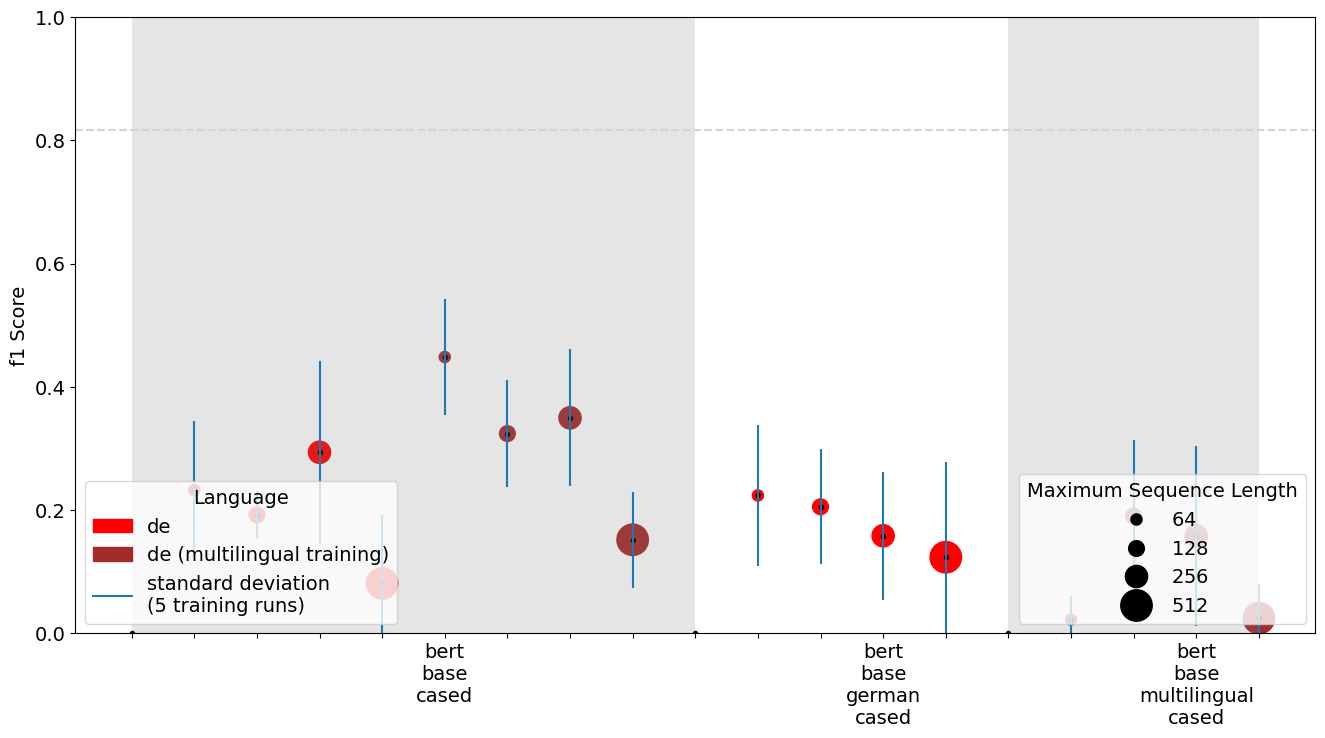

In [27]:
plot_results(grouped_ne_test, ["de", "multilingual-de"], set="test", score="f1")

In [28]:
global_sent_metrics = get_global_sent_metrics(sent_test_metrics, sent_dev_metrics)
global_sent_metrics.head()

,model,max_sequence_length,epochs,suffix,language,run,set,label,precision,recall,f1,support
0,bert_base_german_cased,128,3,_run_de_2,de,2,dev,0,0.7778,0.6087,0.6829,23
1,bert_base_german_cased,128,3,_run_de_2,de,2,dev,1,0.9912,0.9961,0.9937,1022
2,bert_base_german_cased,128,3,_run_de_2,de,2,dev,accuracy,0.9876,0.9876,0.9876,1045
3,bert_base_german_cased,128,3,_run_de_2,de,2,dev,macro_avg,0.8845,0.8024,0.8383,1045
0,bert_base_german_cased,128,3,_run_de_2,de,2,test,0,0.8889,0.6400,0.7442,50


In [35]:
sent_test = global_sent_metrics[(global_sent_metrics["set"] == "test") &
                                (global_sent_metrics["label"].isin(["0", "1", "accuracy", "macro_avg"]))]
grouped_sent_test = sent_test.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", 
                                                                                   "f1": [np.mean, np.std],
                                                                                   "precision": [np.mean, np.std],
                                                                                   "recall": [np.mean, np.std]}).reset_index()
grouped_sent_test

model language max_sequence_length  \
                                                                           
0                           bert_base_cased       de                  64   
1                           bert_base_cased       de                  64   
2                           bert_base_cased       de                  64   
3                           bert_base_cased       de                  64   
4                           bert_base_cased       de                 128   
..                                      ...      ...                 ...   
123  dbmdz_bert_base_french_europeana_cased       fr                 256   
124  dbmdz_bert_base_french_europeana_cased       fr                 512   
125  dbmdz_bert_base_french_europeana_cased       fr                 512   
126  dbmdz_bert_base_french_europeana_cased       fr                 512   
127  dbmdz_bert_base_french_europeana_cased       fr                 512   

         label   run       f1           precision             recall            
               count     mean       std      mean       std     mean       std  
0            0     5  0.74864  0.023812   0.78504  0.015803  0.71600  0.035777  
1            1     5  0.98832  0.000896   0.98626  0.001699  0.99046  0.000789  
2     accuracy     5  0.97770  0.001751   0.97770  0.001751  0.97770  0.001751  
3    macro_avg     5  0.86850  0.012365   0.88566  0.008325  0.85320  0.017837  
4            0     5  0.71044  0.045718   0.76470  0.040826  0.66400  0.053666  
..         ...   ...      ...       ...       ...       ...      ...       ...  
123  macro_avg     5  0.86394  0.014053   0.92828  0.007704  0.81818  0.017894  
124          0     5  0.64214  0.104705   0.86128  0.051701  0.51732  0.120052  
125          1     5  0.98474  0.003612   0.97410  0.006317  0.99560  0.001518  
126   accuracy     5  0.97070  0.006927   0.97070  0.006927  0.97070  0.006927  
127  macro_avg     5  0.81344  0.054145   0.91770  0.028400  0.75648  0.060333  

[128 rows x 11 columns]

In [36]:
grouped_sent_test[grouped_sent_test["language"].isin(["de", "multilingual-de"])]

model         language max_sequence_length  \
                                                                        
0                bert_base_cased               de                  64   
1                bert_base_cased               de                  64   
2                bert_base_cased               de                  64   
3                bert_base_cased               de                  64   
4                bert_base_cased               de                 128   
..                           ...              ...                 ...   
91  bert_base_multilingual_cased  multilingual-de                 256   
92  bert_base_multilingual_cased  multilingual-de                 512   
93  bert_base_multilingual_cased  multilingual-de                 512   
94  bert_base_multilingual_cased  multilingual-de                 512   
95  bert_base_multilingual_cased  multilingual-de                 512   

        label   run       f1           precision             recall            
              count     mean       std      mean       std     mean       std  
0           0     5  0.74864  0.023812   0.78504  0.015803  0.71600  0.035777  
1           1     5  0.98832  0.000896   0.98626  0.001699  0.99046  0.000789  
2    accuracy     5  0.97770  0.001751   0.97770  0.001751  0.97770  0.001751  
3   macro_avg     5  0.86850  0.012365   0.88566  0.008325  0.85320  0.017837  
4           0     5  0.71044  0.045718   0.76470  0.040826  0.66400  0.053666  
..        ...   ...      ...       ...       ...       ...      ...       ...  
91  macro_avg     5  0.81090  0.045137   0.85286  0.028927  0.78084  0.055545  
92          0     5  0.49568  0.269185   0.69542  0.113927  0.43600  0.308350  
93          1     5  0.98270  0.005112   0.97328  0.014238  0.99240  0.004849  
94   accuracy     5  0.96658  0.010169   0.96658  0.010169  0.96658  0.010169  
95  macro_avg     5  0.73920  0.137100   0.83434  0.062141  0.71420  0.151932  

[64 rows x 11 columns]

/scratch/students/marxen/text-classification-baseline/helpers/helpersParsingResults.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


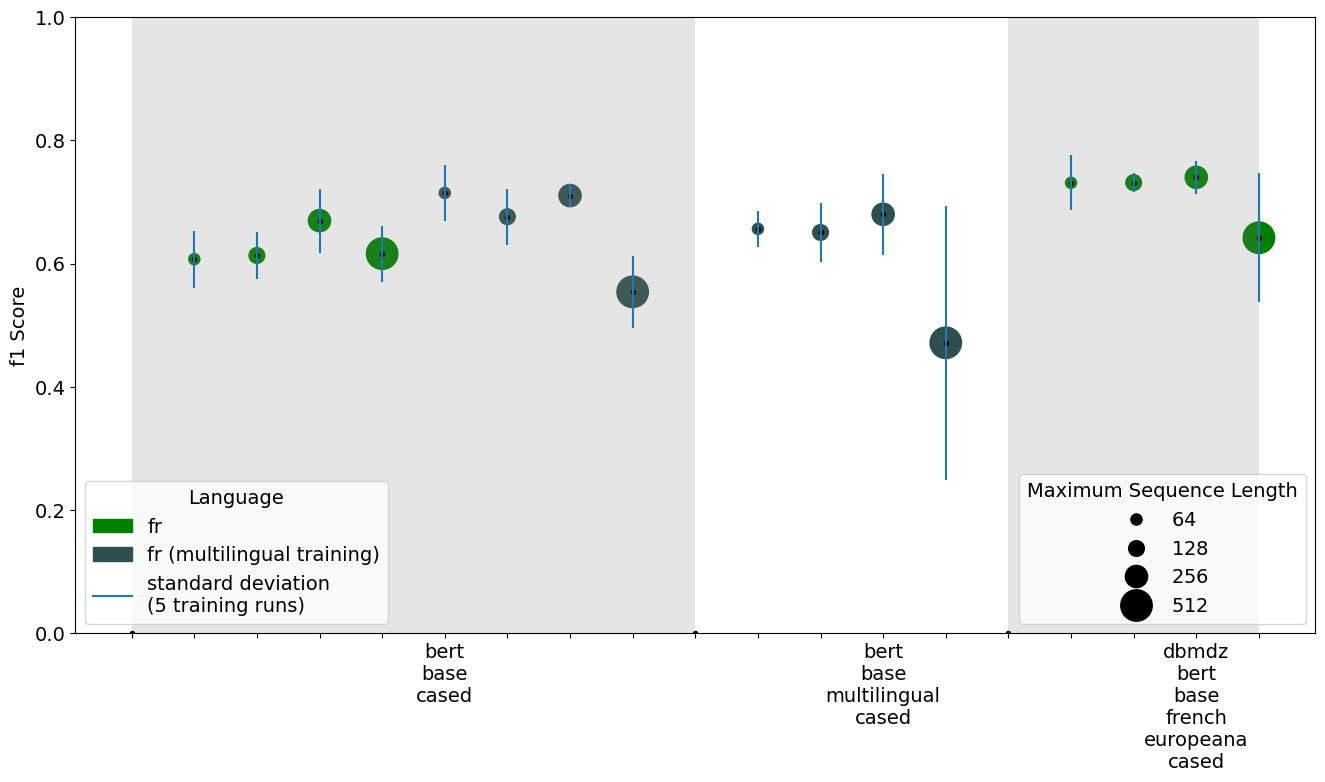

In [37]:
plot_results(grouped_sent_test[grouped_sent_test["label"]=="0"], ["fr", "multilingual-fr"], add_baseline=False)

/scratch/students/marxen/text-classification-baseline/helpers/helpersParsingResults.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


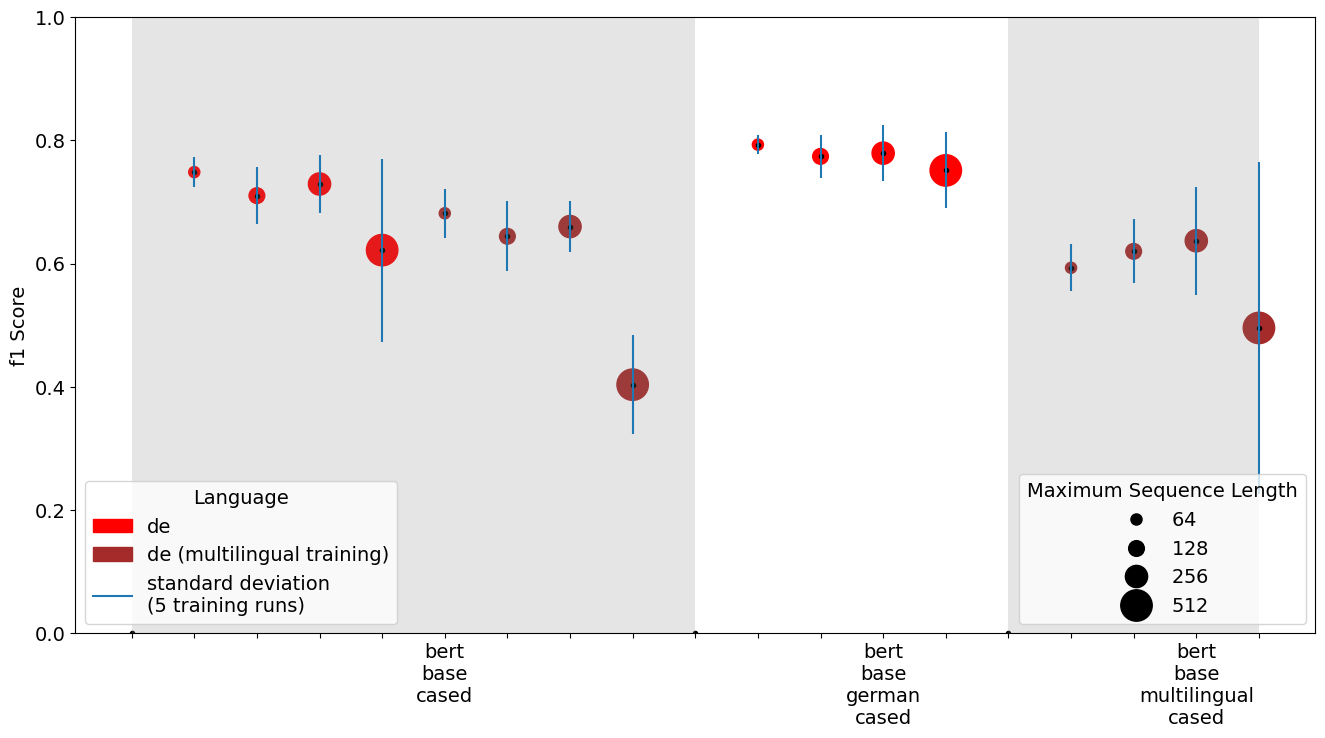

In [38]:
plot_results(grouped_sent_test[grouped_sent_test["label"]=="0"], ["de", "multilingual-de"], add_baseline=False)

In [39]:
grouped_sent_test[grouped_sent_test["model"]=="dbmdz_bert_base_french_europeana_cased"]

model language max_sequence_length  \
                                                                           
112  dbmdz_bert_base_french_europeana_cased       fr                  64   
113  dbmdz_bert_base_french_europeana_cased       fr                  64   
114  dbmdz_bert_base_french_europeana_cased       fr                  64   
115  dbmdz_bert_base_french_europeana_cased       fr                  64   
116  dbmdz_bert_base_french_europeana_cased       fr                 128   
117  dbmdz_bert_base_french_europeana_cased       fr                 128   
118  dbmdz_bert_base_french_europeana_cased       fr                 128   
119  dbmdz_bert_base_french_europeana_cased       fr                 128   
120  dbmdz_bert_base_french_europeana_cased       fr                 256   
121  dbmdz_bert_base_french_europeana_cased       fr                 256   
122  dbmdz_bert_base_french_europeana_cased       fr                 256   
123  dbmdz_bert_base_french_europeana_cased       fr                 256   
124  dbmdz_bert_base_french_europeana_cased       fr                 512   
125  dbmdz_bert_base_french_europeana_cased       fr                 512   
126  dbmdz_bert_base_french_europeana_cased       fr                 512   
127  dbmdz_bert_base_french_europeana_cased       fr                 512   

         label   run       f1           precision             recall            
               count     mean       std      mean       std     mean       std  
112          0     5  0.73128  0.044470   0.90512  0.021680  0.61466  0.054443  
113          1     5  0.98778  0.001579   0.97922  0.002883  0.99650  0.000693  
114   accuracy     5  0.97660  0.003063   0.97660  0.003063  0.97660  0.003063  
115  macro_avg     5  0.85952  0.023042   0.94218  0.011811  0.80560  0.027316  
116          0     5  0.73160  0.015466   0.87152  0.023727  0.63066  0.018017  
117          1     5  0.98738  0.000746   0.98004  0.000961  0.99486  0.001055  
118   accuracy     5  0.97590  0.001384   0.97590  0.001384  0.97590  0.001384  
119  macro_avg     5  0.85948  0.008065   0.92578  0.011962  0.81276  0.009013  
120          0     5  0.74018  0.027031   0.87596  0.014326  0.64134  0.035707  
121          1     5  0.98776  0.001041   0.98062  0.001903  0.99502  0.000554  
122   accuracy     5  0.97662  0.001990   0.97662  0.001990  0.97662  0.001990  
123  macro_avg     5  0.86394  0.014053   0.92828  0.007704  0.81818  0.017894  
124          0     5  0.64214  0.104705   0.86128  0.051701  0.51732  0.120052  
125          1     5  0.98474  0.003612   0.97410  0.006317  0.99560  0.001518  
126   accuracy     5  0.97070  0.006927   0.97070  0.006927  0.97070  0.006927  
127  macro_avg     5  0.81344  0.054145   0.91770  0.028400  0.75648  0.060333

In [40]:
grouped_sent_test[grouped_sent_test["model"]=="bert_base_german_cased"]

model language max_sequence_length      label   run  \
                                                                   count   
64  bert_base_german_cased       de                  64          0     5   
65  bert_base_german_cased       de                  64          1     5   
66  bert_base_german_cased       de                  64   accuracy     5   
67  bert_base_german_cased       de                  64  macro_avg     5   
68  bert_base_german_cased       de                 128          0     5   
69  bert_base_german_cased       de                 128          1     5   
70  bert_base_german_cased       de                 128   accuracy     5   
71  bert_base_german_cased       de                 128  macro_avg     5   
72  bert_base_german_cased       de                 256          0     5   
73  bert_base_german_cased       de                 256          1     5   
74  bert_base_german_cased       de                 256   accuracy     5   
75  bert_base_german_cased       de                 256  macro_avg     5   
76  bert_base_german_cased       de                 512          0     5   
77  bert_base_german_cased       de                 512          1     5   
78  bert_base_german_cased       de                 512   accuracy     5   
79  bert_base_german_cased       de                 512  macro_avg     5   

         f1           precision             recall            
       mean       std      mean       std     mean       std  
64  0.79326  0.015693   0.79606  0.018550  0.79200  0.041473  
65  0.98998  0.000559   0.98986  0.001992  0.99006  0.001607  
66  0.98088  0.001062   0.98088  0.001062  0.98088  0.001062  
67  0.89160  0.008108   0.89296  0.008670  0.89102  0.020095  
68  0.77416  0.034933   0.82708  0.038457  0.73200  0.071554  
69  0.98970  0.001247   0.98702  0.003406  0.99240  0.002215  
70  0.98032  0.002397   0.98032  0.002397  0.98032  0.002397  
71  0.88194  0.018042   0.90706  0.018462  0.86220  0.034997  
72  0.77940  0.045146   0.80878  0.032379  0.75600  0.082946  
73  0.98970  0.001748   0.98818  0.003959  0.99126  0.001950  
74  0.98032  0.003339   0.98032  0.003339  0.98032  0.003339  
75  0.88452  0.023436   0.89848  0.016244  0.87360  0.041000  
76  0.75142  0.061802   0.82118  0.059480  0.70800  0.134611  
77  0.98896  0.001746   0.98594  0.006405  0.99200  0.004051  
78  0.97884  0.003442   0.97884  0.003442  0.97884  0.003442  
79  0.87018  0.031760   0.90354  0.027699  0.85000  0.065540

In [41]:
newag_pred_dir = os.path.join("experiments_newag/")
newag_true_dir = os.path.join(DATA_DIR, "2_new_ag/")

newag_true_files = {"de": {"dev": "de/newsagency-data-2-dev-de_newags.tsv", 
                     "test": "de/newsagency-data-2-test-de_newags.tsv"},
              "fr": {"dev": "fr/newsagency-data-2-dev-fr_newags.tsv", 
                     "test": "fr/newsagency-data-2-test-fr_newags.tsv"}
}

newag_pred_files = {
    "de": {"dev": "newsagency-data-2-dev-de_newags_pred.tsv", 
           "test": "newsagency-data-2-test-de_newags_pred.tsv"},
    "fr": {"dev": "newsagency-data-2-dev-fr_newags_pred.tsv", 
           "test": "newsagency-data-2-test-fr_newags_pred.tsv"}
}

In [42]:
df_best_newag = get_all_best_model_runs(newag_pred_dir)
df_best_newag.head()

,index,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1,name,lang,modelname
4,243,bert_base_german_cased,128,3,_run_de_3,test,de,3,0.111593,0.457143,0.301887,0.363636,bert_base_german_cased_128_de_test,de,model_bert_base_german_cased_max_sequence_leng...
1,9,bert_base_multilingual_cased,256,3,_run_multilingual-de_3,test,multilingual-de,3,0.167912,0.369565,0.320755,0.343434,bert_base_multilingual_cased_256_multilingual-...,multilingual,model_bert_base_multilingual_cased_max_sequenc...
2,159,bert_base_multilingual_cased,256,3,_run_multilingual-fr_2,test,multilingual-fr,2,0.162496,0.417476,0.272152,0.329502,bert_base_multilingual_cased_256_multilingual-...,multilingual,model_bert_base_multilingual_cased_max_sequenc...
2,71,bert_base_cased,64,3,_run_fr_4,test,fr,4,0.169870,0.269231,0.143836,0.187500,bert_base_cased_64_fr_test,fr,model_bert_base_cased_max_sequence_length_64_e...
2,171,bert_base_cased,128,3,_run_de_1,test,de,1,0.151960,0.263158,0.196078,0.224719,bert_base_cased_128_de_test,de,model_bert_base_cased_max_sequence_length_128_...


In [43]:
imported_newag_models = {}
for i, row in df_best_newag.iterrows():
    if "multilingual" in row["language"]:
        lang = row["language"][-2:]
    else:
        lang = row["language"]
    imported_newag_models[row["name"]] = parse_tsv_gt_and_prediction(row["modelname"], row["set"], lang, 
                                                                     newag_true_dir, newag_true_files, newag_pred_dir, newag_pred_files)


In [44]:
for model, model_df in imported_newag_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratios(model_df)}\n")

bert_base_german_cased_128_de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 47.06, 'at_end': None}

bert_base_multilingual_cased_256_multilingual-de_test - % of correctly predicted news agencies:
{'at_beginning': 66.67, 'in_middle': 33.33, 'at_end': None}

bert_base_multilingual_cased_256_multilingual-fr_test - % of correctly predicted news agencies:
{'at_beginning': 16.67, 'in_middle': 32.98, 'at_end': 85.71}

bert_base_cased_64_fr_test - % of correctly predicted news agencies:
{'at_beginning': 0.0, 'in_middle': 18.67, 'at_end': 60.0}

bert_base_cased_128_de_test - % of correctly predicted news agencies:
{'at_beginning': 0.0, 'in_middle': 30.56, 'at_end': None}

bert_base_cased_256_de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 62.86, 'at_end': None}

bert_base_cased_512_multilingual-de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 42.86, 'at_end': None}

bert_base_cased

[]

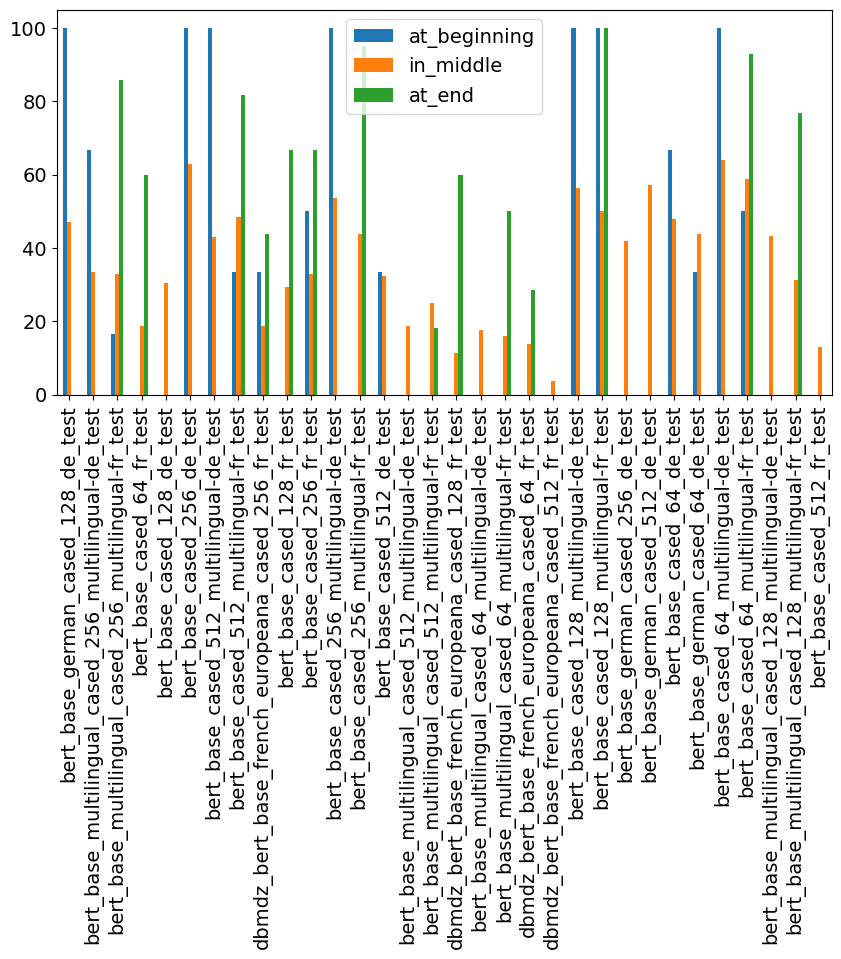

In [45]:
df_pos_newag = get_all_df_pos(imported_newag_models)

fig, ax = plt.subplots(figsize=(10, 5))
df_pos_newag.plot.bar(ax=ax)
ax.set_xticklabels(df_pos_newag["model"])
plt.plot()

In [46]:
imported_newag_models["bert_base_cased_128_de_test"].head(20)

,token,pred_ag,true_ag,pos_in_doc,len_doc,LED,is_correct_class,at_beginning,at_end,in_middle
0,Canadian,O,unk,23.0,1225.0,0.0,False,False,False,True
1,Press,O,unk,24.0,1225.0,0.0,False,False,False,True
2,PA,AP,unk,459.0,1225.0,0.0,False,False,False,True
3,SPT,unk,unk,536.0,1225.0,0.0,True,False,False,True
4,Canadian,unk,unk,672.0,1225.0,0.0,True,False,False,True
5,Press,UP-UPI,unk,673.0,1225.0,0.0,False,False,False,True
6,CAPA,unk,unk,742.0,1225.0,0.0,True,False,False,True
7,Fides,O,unk,842.0,1225.0,0.0,False,False,False,True
8,AGERPRESS,O,unk,925.0,1225.0,0.0,False,False,False,True
9,NTB,DNB,unk,993.0,1225.0,0.0,False,False,False,True


In [47]:
imported_newag_models["bert_base_cased_128_fr_test"].sum()

token               AgencedeConstantinopleAgencetÃ©lÃ©graphiqueott...
pred_ag             ATS-SDAOOATS-SDAATS-SDAOOarticleauthorATS-SDAO...
true_ag             unkunkunkunkunkunkunkunkunkunkunkunkunkunkunku...
pos_in_doc                                                    93174.0
len_doc                                                      174240.0
LED                                                               0.0
is_correct_class                                                   31
at_beginning                                                       15
at_end                                                             25
in_middle                                                         178
dtype: object

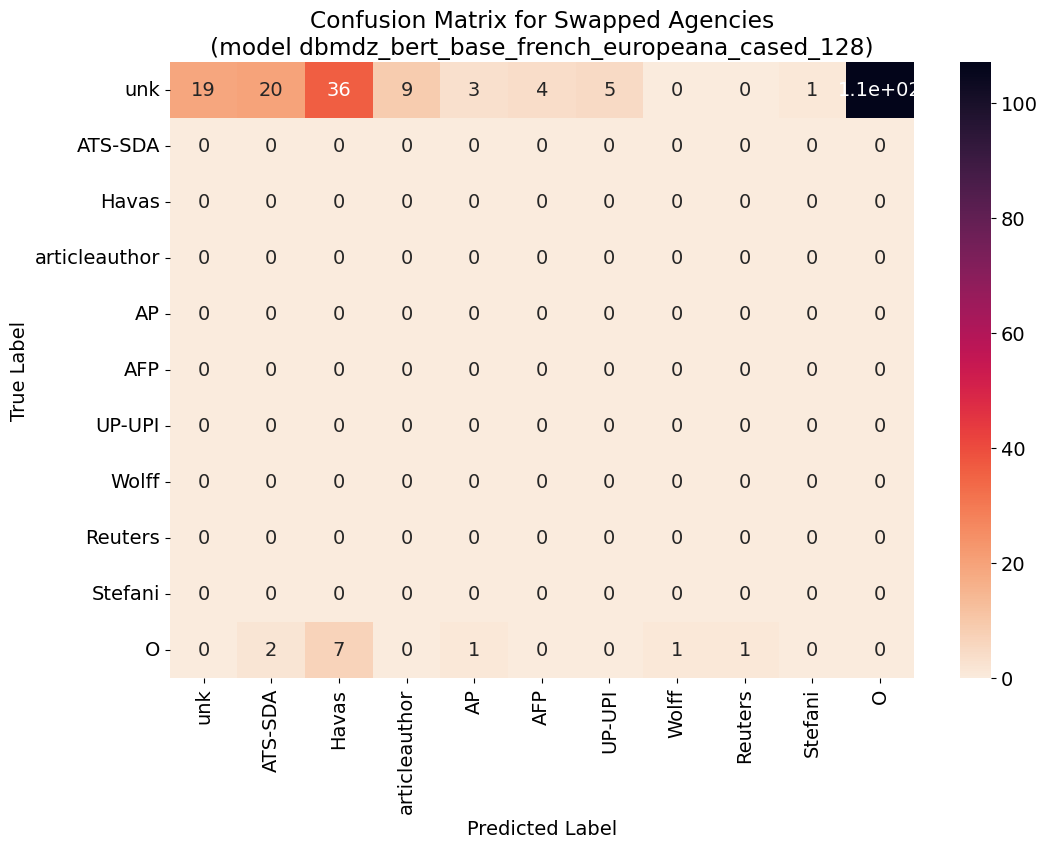

In [48]:
plot_confusion_matrix(imported_newag_models["dbmdz_bert_base_french_europeana_cased_128_fr_test"], "Confusion Matrix for Swapped Agencies\n(model dbmdz_bert_base_french_europeana_cased_128)")

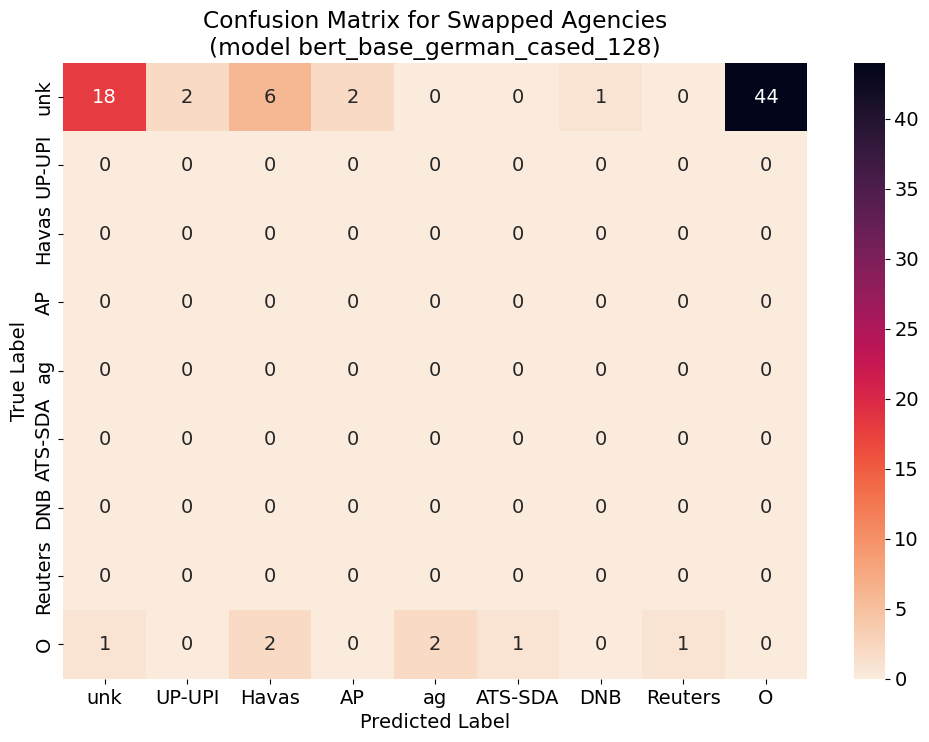

In [49]:
plot_confusion_matrix(imported_newag_models["bert_base_german_cased_128_de_test"], "Confusion Matrix for Swapped Agencies\n(model bert_base_german_cased_128)")

### Save New Agency Stats

In [50]:
grouped_ne_test.head()

model language max_sequence_length   run        f1            \
                                                count      mean       std   
0  bert_base_cased       de                  64     5  0.232300  0.111651   
1  bert_base_cased       de                 128     5  0.192137  0.038540   
2  bert_base_cased       de                 256     5  0.293807  0.148715   
3  bert_base_cased       de                 512     5  0.080885  0.110870   
4  bert_base_cased       fr                  64     5  0.152923  0.040328   

  precision              recall            
       mean       std      mean       std  
0  0.260779  0.104837  0.211765  0.117156  
1  0.245027  0.063944  0.160784  0.032219  
2  0.361454  0.198154  0.249057  0.119629  
3  0.113393  0.155278  0.062963  0.086464  
4  0.228249  0.061046  0.115068  0.030400

In [51]:
grouped_sent_test.head()

model language max_sequence_length      label   run       f1  \
                                                           count     mean   
0  bert_base_cased       de                  64          0     5  0.74864   
1  bert_base_cased       de                  64          1     5  0.98832   
2  bert_base_cased       de                  64   accuracy     5  0.97770   
3  bert_base_cased       de                  64  macro_avg     5  0.86850   
4  bert_base_cased       de                 128          0     5  0.71044   

            precision             recall            
        std      mean       std     mean       std  
0  0.023812   0.78504  0.015803  0.71600  0.035777  
1  0.000896   0.98626  0.001699  0.99046  0.000789  
2  0.001751   0.97770  0.001751  0.97770  0.001751  
3  0.012365   0.88566  0.008325  0.85320  0.017837  
4  0.045718   0.76470  0.040826  0.66400  0.053666

In [58]:
both_newag_results = []

for name, stats in {"grouped_ne_test": grouped_ne_test, "grouped_sent_test": grouped_sent_test}.items():
    df = stats.copy()
    #get rid of multiindex
    df.columns = df.columns.map('_'.join)
    #round float numbers to 3 decimal places
    col_select = [col for col in df.columns if ("mean" in col) or ("std" in col)]
    df[col_select] = df[col_select].round(3)

    for metric in ["f1", "precision", "recall"]:
        df[metric] = df.apply(lambda row: str(row[f"{metric}_mean"]) + " (" + str(row[f"{metric}_std"]) + ")", axis=1)
        df = df.drop(columns=[f"{metric}_mean", f"{metric}_std"])

    #formatting
    df = df.drop(columns=["run_count"])
    if "_ne_" in name:
        df.columns = ["Model", "Language", "Max. Sequence Length", 
                  "F1", "Precision", "Recall"]
        # save results
        print(f"save df to '{name}_newag.csv'")
        df.to_csv(f'{name}_newag.csv')

    elif "_sent_" in name:
        df.columns = ["Model", "Language", "Max. Sequence Length", "Label",
                  "F1", "Precision", "Recall"]
        df = df[df["Label"] == "accuracy"].drop(columns="Label")
        #save two different results
        #micro avg/accuracy (same for two-class problem)
        print(f"save df to '{name}_newag.csv'")
        df.to_csv(f'{name}_newag.csv')
    
    both_newag_results.append(df)    

save df to 'grouped_ne_test_newag.csv'
save df to 'grouped_sent_test_newag.csv'


In [62]:
df_both_newag = both_newag_results[0].merge(both_newag_results[1], on= ["Model", "Language", "Max. Sequence Length"], suffixes=(' (NE)', ' (Sent)'))
df_both_newag.head()

,Model,Language,Max. Sequence Length,F1 (NE),Precision (NE),Recall (NE),F1 (Sent),Precision (Sent),Recall (Sent)
0,bert_base_cased,de,64,0.232 (0.112),0.261 (0.105),0.212 (0.117),0.978 (0.002),0.978 (0.002),0.978 (0.002)
1,bert_base_cased,de,128,0.192 (0.039),0.245 (0.064),0.161 (0.032),0.975 (0.004),0.975 (0.004),0.975 (0.004)
2,bert_base_cased,de,256,0.294 (0.149),0.361 (0.198),0.249 (0.12),0.977 (0.004),0.977 (0.004),0.977 (0.004)
3,bert_base_cased,de,512,0.081 (0.111),0.113 (0.155),0.063 (0.086),0.971 (0.008),0.971 (0.008),0.971 (0.008)
4,bert_base_cased,fr,64,0.153 (0.04),0.228 (0.061),0.115 (0.03),0.968 (0.003),0.968 (0.003),0.968 (0.003)


In [63]:
df_both_newag.to_csv("results_newag.csv")